In [1]:
from src.libs import *
from src.helper_functions import *
from src.model_manager import *
from jupyter_bbox_widget import BBoxWidget

# fill memory bank

In [2]:
# build model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_manager = ModelManager(device=device)
model_manager.load_sam2_model(sam2_model_type='tiny', points_per_side=32)


dino_model_name1 = 'dinov2_vitl14' # dinov2_vits14, dinov2_vitb14, dinov2_vitl14, dinov2_vitg14
dinov2_model, dinov2_transform = model_manager.load_dino_model(dino_model_name=dino_model_name1, weights=None)


dino_model_name2 = 'dinov3_vitl16' # dinov3_vits16, dinov3_vits16plus, dinov3_vitb16, dinov3_vitl16, dinov3_vith16plus, dinov3_vit7b16
weights = 'checkpoints\dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth'
dinov3_model, dinov3_transform = model_manager.load_dino_model(dino_model_name=dino_model_name2, weights=weights)
print('Done!')

Using cache found in C:\Users\ADMIN/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\ADMIN/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\ADMIN/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\ADMIN/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Done!


In [3]:
# load image
img_path = r'assets\2762.jpg'
img = Image.open(img_path).convert('RGB')
ori_w, ori_h = img.size

widget = BBoxWidget()
widget.image = encode_image(img_path)
widget

In [7]:
boxes = widget.bboxes
ref_boxes = []
for box in boxes:
    x1, y1, x2, y2 = box['x'], box['y'], box['x'] + box['width'], box['y'] + box['height']
    ref_boxes.append([x1, y1, x2, y2])


print('len(ref_boxes): ', len(ref_boxes))
input_box = np.array(ref_boxes)

len(ref_boxes):  1


In [8]:
device = model_manager.device
ref_masks = []
reference_data = {}
if len(ref_boxes) > 0:
    with torch.inference_mode(), torch.autocast(device, dtype=torch.bfloat16):
        model_manager.sam2_predictor.set_image(img)
        masks, scores, _ = model_manager.sam2_predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box[None, :],
            multimask_output=False,
        )

    ref_masks = masks[:, 0] if len(ref_boxes) > 1 else masks

    cls_nm = 'orange'

    reference_data = {
        cls_nm: [
            {
                'img_path': img_path,
                'masks': ref_masks
            }
        ]
    }

# memory_bank = build_memory_bank(
#     reference_data=reference_data, 
#     dino_model=model_manager.dino_model, 
#     dino_transform=model_manager.dino_transform, 
#     model_name=dino_model_name,
#     device=device
# )

# build memory bank with dinov2
memory_bank1 = build_memory_bank(
    reference_data=reference_data, 
    dino_model=dinov2_model, 
    dino_transform=dinov2_transform, 
    model_name=dino_model_name1,
    device=device
)

# build memory bank with dinov3
memory_bank2 = build_memory_bank(
    reference_data=reference_data, 
    dino_model=dinov3_model, 
    dino_transform=dinov3_transform, 
    model_name=dino_model_name2,
    device=device
)


torch.cuda.empty_cache()

Building Memory Bank...


100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


Memory Bank Built.
Building Memory Bank...


100%|██████████| 1/1 [00:00<00:00, 11.49it/s]

Memory Bank Built.


# visualize support masks

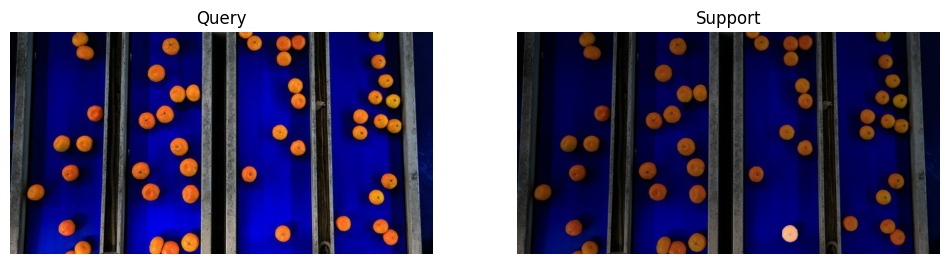

In [9]:
n_cols = 1 + len(ref_boxes)

fig, axes = plt.subplots(1, n_cols, figsize=(12, 12))
axes[0].imshow(img)
axes[0].set_title('Query')
axes[0].axis('off')

for i in range(n_cols - 1):
    axes[i + 1].imshow(img)
    axes[i + 1].imshow(ref_masks[i], cmap='gray', alpha=0.4) 
    axes[i + 1].set_title('Support')
    axes[i + 1].axis('off')

# Predict

In [10]:
# dinov2 + sam2.1
img_pil1, masks1, final_segmented_instances1 = predict_single_image(
    img_path=img_path, 
    memory_bank=memory_bank1,
    sam2_mask_generator=model_manager.sam2_mask_generator,
    dino_model=dinov2_model,
    dino_transform=dinov2_transform,
    model_name=dino_model_name1,
    min_aera=0.0,
    max_area=None,
    iou_threshold=0.25,
    conf_threshold=0.5,
    device=model_manager.device
)


# dinov3 + sam2.1
img_pil2, masks2, final_segmented_instances2 = predict_single_image(
    img_path=img_path, 
    memory_bank=memory_bank2,
    sam2_mask_generator=model_manager.sam2_mask_generator,
    dino_model=dinov3_model,
    dino_transform=dinov3_transform,
    model_name=dino_model_name2,
    min_aera=0.0,
    max_area=None,
    iou_threshold=0.25,
    conf_threshold=0.5,
    device=model_manager.device
)

torch.cuda.empty_cache()

# Automatic mask generation

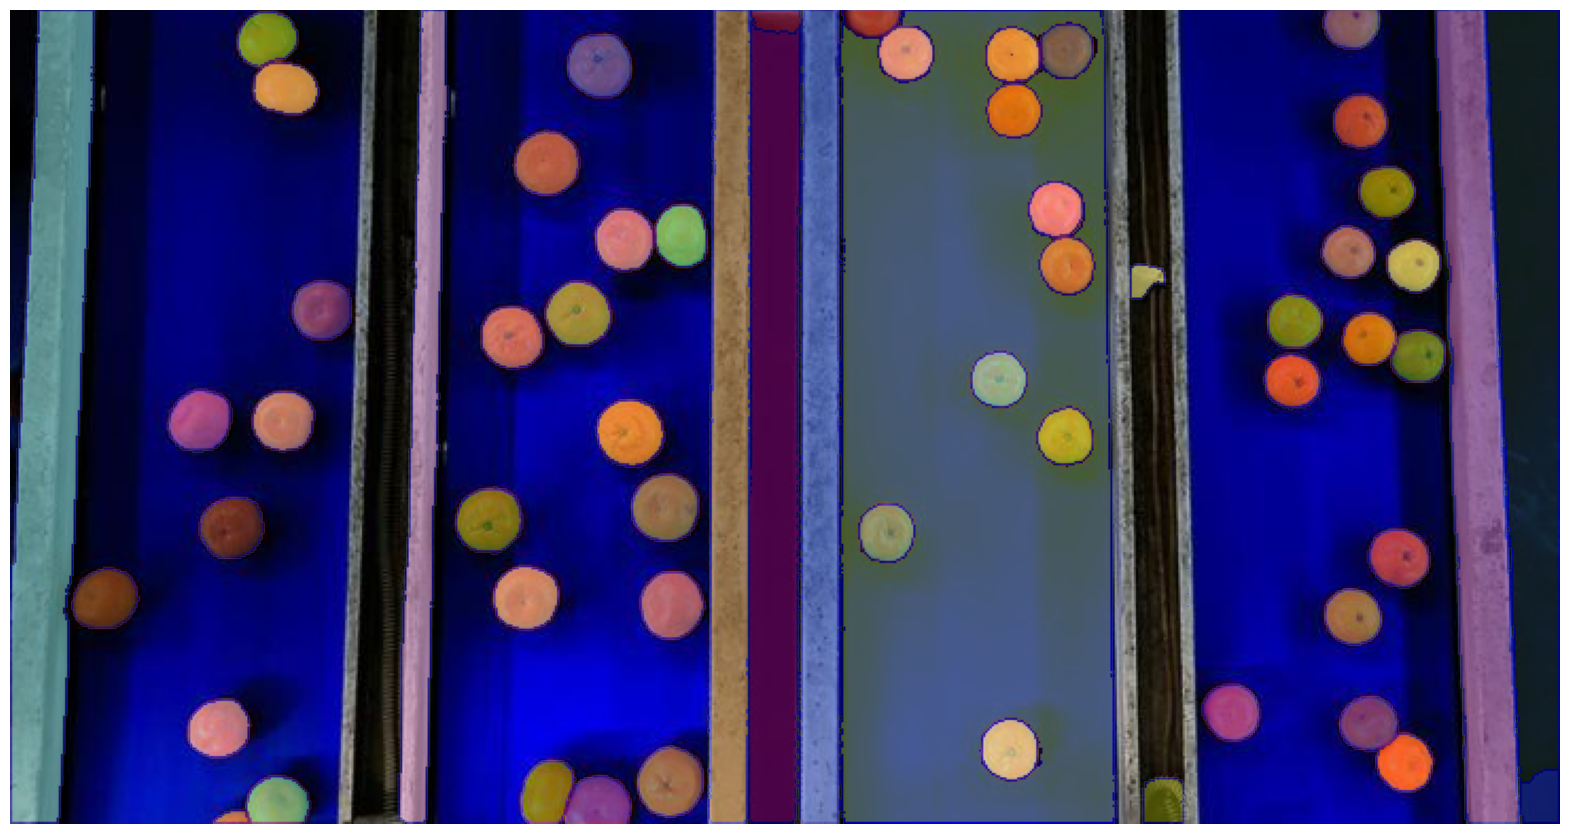

In [11]:
plt.figure(figsize=(20, 20))
plt.imshow(img_pil1)
show_anns(masks1)
plt.axis('off')
plt.show()

# Result

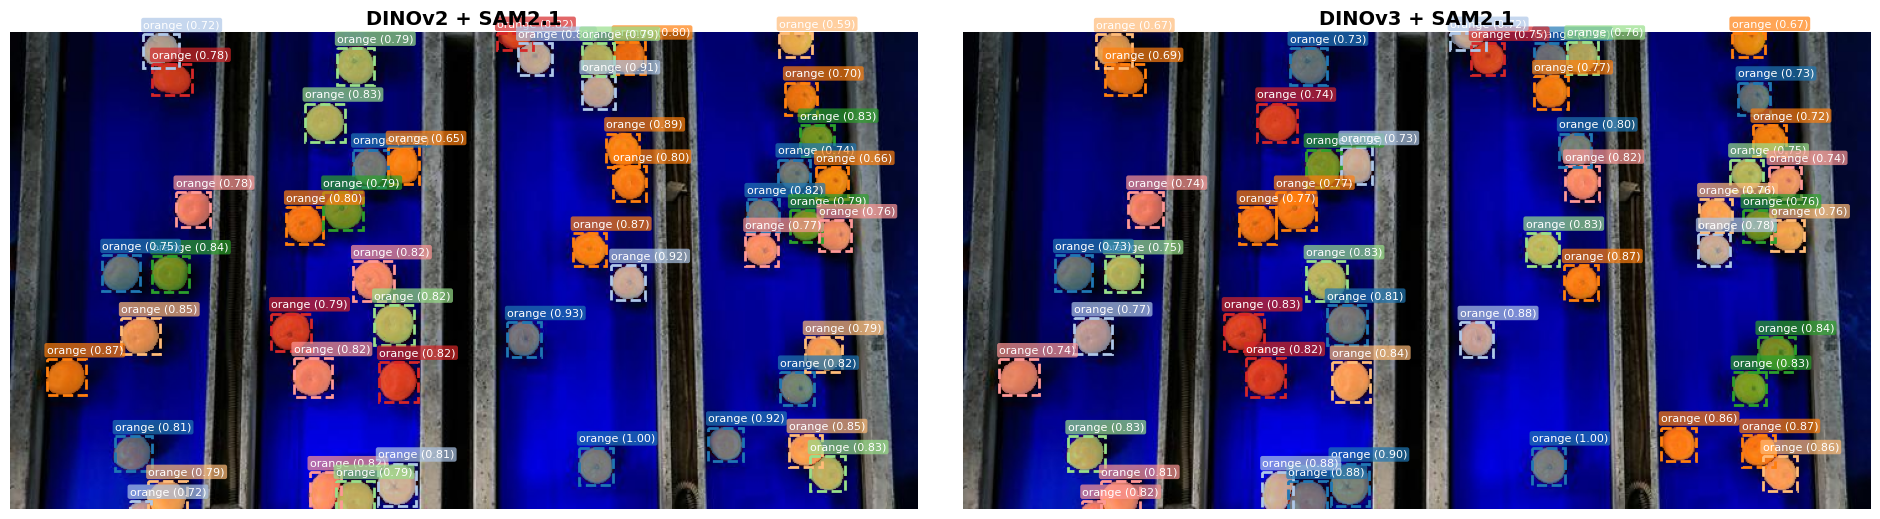

In [12]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(24, 48))
gs = gridspec.GridSpec(1, 2, figure=fig, wspace=0.05)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

visualize_results(img_path, final_segmented_instances1, ax=ax1, title="DINOv2 + SAM2.1")
visualize_results(img_path, final_segmented_instances2, ax=ax2, title="DINOv3 + SAM2.1")

plt.show()